In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import io
import matplotlib.font_manager as fm

### Variáveis
## Cores
protocol_colors = {
    'grpc': '#ffb366',
    'thrift': '#66b3ff',
    'rest': '#99ff99'
}

# Carregando os dados do arquivo CSV em um DataFrame do pandas
# df_results = pd.read_csv('./drive/MyDrive/MPES/Dados/all_results.csv')
df_results = pd.read_csv('./dados/all_results.csv')

# Exibindo as primeiras linhas para confirmar que os dados foram carregados corretamente
print("Amostra dos dados carregados de all_results.csv:")
print(df_results.head())

Amostra dos dados carregados de all_results.csv:
  scenario protocol  run  latency_ms  cpu_usage_percent  memory_usage_mb  \
0  simples     grpc    1      340.13              13.18           328.86   
1  simples     grpc    2      263.77              12.59           311.69   
2  simples     grpc    3      149.22              12.64           303.82   
3  simples     grpc    4      206.49              12.04           309.10   
4  simples     grpc    5      301.95              12.60           245.45   

   throughput_req_s  
0           3564.30  
1           3905.04  
2           3801.51  
3           3564.84  
4           3629.74  


In [4]:
# Renomeando as colunas do DataFrame df_results para facilitar a referência
df_results.columns = ['scenario', 'protocol', 'run', 'latency_ms', 'cpu_usage_percent', 'memory_usage_mb', 'throughput_req_s']

# Agrupando os dados por 'scenario' e 'protocol' e calculando as métricas solicitadas
summary_table = df_results.groupby(['scenario', 'protocol']).agg(
    latency_ms_avg=('latency_ms', 'mean'),
    latency_ms_max=('latency_ms', 'max'),
    latency_ms_p90=('latency_ms', lambda x: x.quantile(0.90)),
    latency_ms_p95=('latency_ms', lambda x: x.quantile(0.95)),
    cpu_usage_percent_avg=('cpu_usage_percent', 'mean'),
    cpu_usage_percent_max=('cpu_usage_percent', 'max'),
    cpu_usage_percent_p90=('cpu_usage_percent', lambda x: x.quantile(0.90)),
    cpu_usage_percent_p95=('cpu_usage_percent', lambda x: x.quantile(0.95)),
    memory_usage_mb_avg=('memory_usage_mb', 'mean'),
    memory_usage_mb_max=('memory_usage_mb', 'max'),
    memory_usage_mb_p90=('memory_usage_mb', lambda x: x.quantile(0.90)),
    memory_usage_mb_p95=('memory_usage_mb', lambda x: x.quantile(0.95)),
    throughput_req_s_avg=('throughput_req_s', 'mean'),
    throughput_req_s_max=('throughput_req_s', 'max'),
    throughput_req_s_p90=('throughput_req_s', lambda x: x.quantile(0.90)),
    throughput_req_s_p95=('throughput_req_s', lambda x: x.quantile(0.95))
)

# Exibindo a tabela resumo com valores arredondados para 2 casas decimais
display(summary_table.round(2))

latency_ms_avg  latency_ms_max  latency_ms_p90  \
scenario    protocol                                                   
complexo    grpc             5462.68         5499.37         5486.74   
            rest             6000.97         6002.16         6001.85   
            thrift           5721.15         6000.96         6000.58   
simples     grpc              280.60          536.43          437.34   
            rest              477.25          653.16          586.21   
            thrift            345.87          545.47          411.38   
tradicional grpc             2749.80         3440.36         3402.76   
            rest             3501.06         5372.78         4980.34   
            thrift           2897.87         3969.82         3892.62   

                      latency_ms_p95  cpu_usage_percent_avg  \
scenario    protocol                                          
complexo    grpc             5490.84                   98.6   
            rest             6002.01                  138.2   
            thrift           6000.76                  106.1   
simples     grpc              500.18                   13.1   
            rest              614.30                   18.1   
            thrift            457.20                   14.0   
tradicional grpc             3422.25                   48.8   
            rest             5175.86                   69.9   
            thrift           3923.65                   52.2   

                      cpu_usage_percent_max  cpu_usage_percent_p90  \
scenario    protocol                                                 
complexo    grpc                     106.90                 105.61   
            rest                     192.28                 143.93   
            thrift                   126.96                 113.15   
simples     grpc                      16.88                  13.80   
            rest                      19.65                  19.07   
            thrift                    16.20                  14.91   
tradicional grpc                      54.58                  52.43   
            rest                      77.45                  76.02   
            thrift                    60.71                  56.80   

                      cpu_usage_percent_p95  memory_usage_mb_avg  \
scenario    protocol                                               
complexo    grpc                     106.27               1167.0   
            rest                     159.71               1426.0   
            thrift                   117.91               1225.0   
simples     grpc                      14.86                303.0   
            rest                      19.29                362.0   
            thrift                    15.48                315.0   
tradicional grpc                      53.54                680.0   
            rest                      76.81                846.0   
            thrift                    58.31                711.0   

                      memory_usage_mb_max  memory_usage_mb_p90  \
scenario    protocol                                             
complexo    grpc                  1357.31              1230.02   
            rest                  1504.87              1498.64   
            thrift                1341.53              1321.76   
simples     grpc                   328.86               320.38   
            rest                   487.48               370.58   
            thrift                 345.65               337.08   
tradicional grpc                   773.73               716.54   
            rest                   925.34               902.62   
            thrift                 789.35               754.39   

                      memory_usage_mb_p95  throughput_req_s_avg  \
scenario    protocol                                              
complexo    grpc                  1279.29                 183.1   
            rest                  1501.63                 166.6   
            thrift  

In [6]:
## Validação dos números usando ANOVA (lib statsmodels)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy import stats

# Realizando a ANOVA para cada métrica, com interação entre protocolo e cenário
metrics_to_analyze = ['latency_ms', 'cpu_usage_percent', 'memory_usage_mb', 'throughput_req_s']
anova_results = {}

for metric in metrics_to_analyze:
    # Two-way ANOVA with interaction
    if metric == 'latency_ms':
        # Apply log transformation to latency data
        df_results[f'{metric}_log'] = np.log(df_results[metric])
        model = ols(f'{metric}_log ~ C(scenario) * C(protocol)', data=df_results).fit()
    else:
        model = ols(f'{metric} ~ C(scenario) * C(protocol)', data=df_results).fit()

    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[metric] = anova_table

# Exibindo os resultados da ANOVA em tabelas separadas
for metric, table in anova_results.items():
    print(f"\nANOVA para {metric} (Cenário * Protocolo):")
    display(table)

# Performing Welch ANOVA for latency_ms across scenarios and protocols separately
print("\nWelch ANOVA para latency_ms por Cenário:")
welch_anova_scenario = stats.f_oneway(*[df_results['latency_ms'][df_results['scenario'] == s] for s in df_results['scenario'].unique()])
print(welch_anova_scenario)

print("\nWelch ANOVA para latency_ms por Protocolo:")
welch_anova_protocol = stats.f_oneway(*[df_results['latency_ms'][df_results['protocol'] == p] for p in df_results['protocol'].unique()])
print(welch_anova_protocol)


ANOVA para latency_ms (Cenário * Protocolo):


,sum_sq,df,F,PR(>F)
C(scenario),193.458003,2.0,1762.540034,7.776763e-93
C(protocol),2.016174,2.0,18.368782,9.991077e-08
C(scenario):C(protocol),1.050905,4.0,4.787247,1.253358e-03
Residual,6.914938,126.0,NaN,NaN



ANOVA para cpu_usage_percent (Cenário * Protocolo):


,sum_sq,df,F,PR(>F)
C(scenario),223351.309351,2.0,2177.700092,1.924330e-98
C(protocol),12267.874004,2.0,119.613135,7.619699e-30
C(scenario):C(protocol),5069.150738,4.0,24.712392,4.092345e-15
Residual,6461.464800,126.0,NaN,NaN



ANOVA para memory_usage_mb (Cenário * Protocolo):


,sum_sq,df,F,PR(>F)
C(scenario),2.022308e+07,2.0,3048.476023,2.002478e-107
C(protocol),6.519113e+05,2.0,98.270697,1.916287e-26
C(scenario):C(protocol),1.651975e+05,4.0,12.451134,1.451127e-08
Residual,4.179315e+05,126.0,NaN,NaN



ANOVA para throughput_req_s (Cenário * Protocolo):


,sum_sq,df,F,PR(>F)
C(scenario),2.028765e+08,2.0,6203.612567,1.397608e-126
C(protocol),6.130671e+06,2.0,187.465273,1.727273e-38
C(scenario):C(protocol),1.013302e+07,4.0,154.925052,1.199418e-47
Residual,2.060287e+06,126.0,NaN,NaN



Welch ANOVA para latency_ms por Cenário:
F_onewayResult(statistic=1093.4249383639085, pvalue=7.077594418250842e-83)

Welch ANOVA para latency_ms por Protocolo:
F_onewayResult(statistic=0.5599660488862469, pvalue=0.5725793613961803)


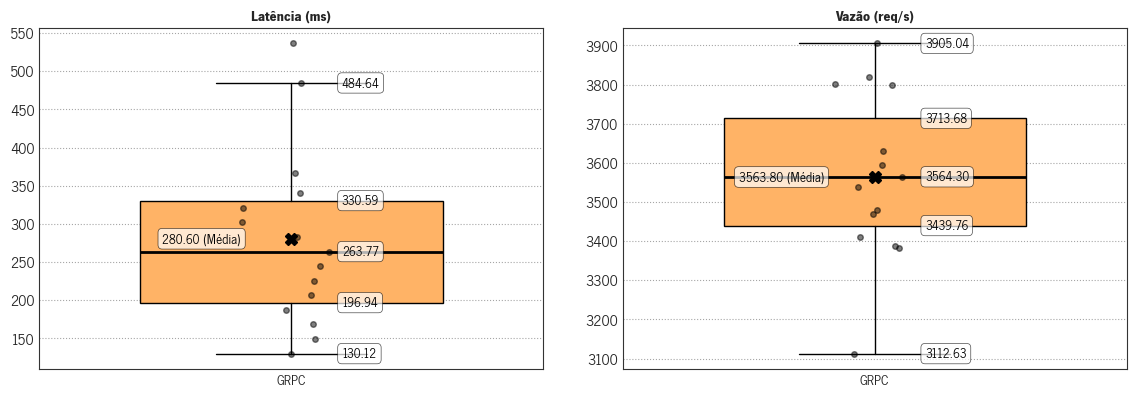

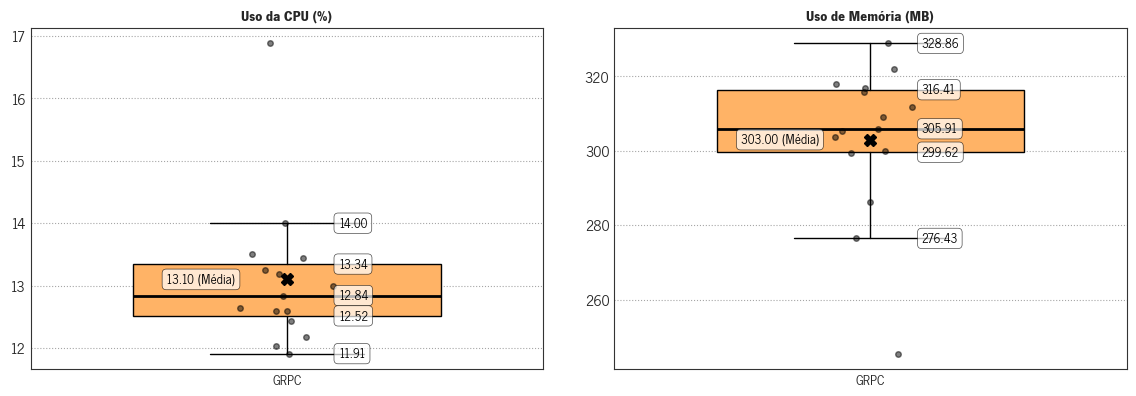

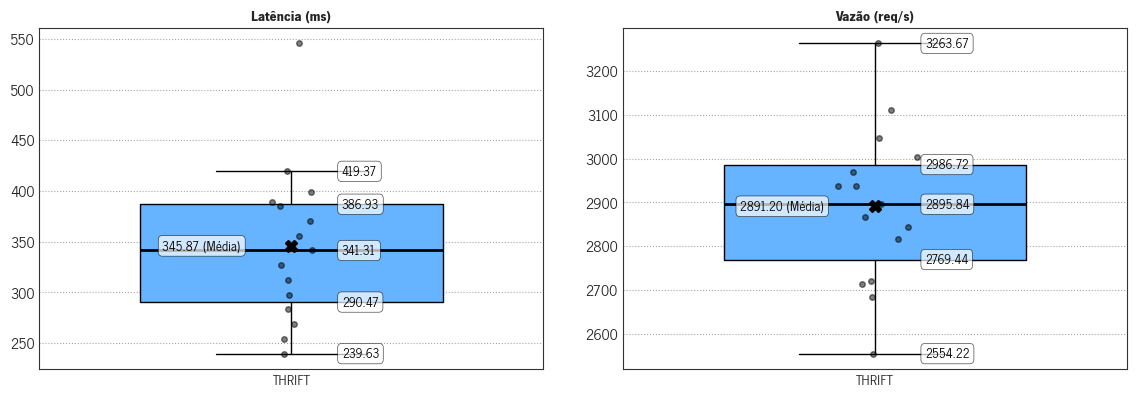

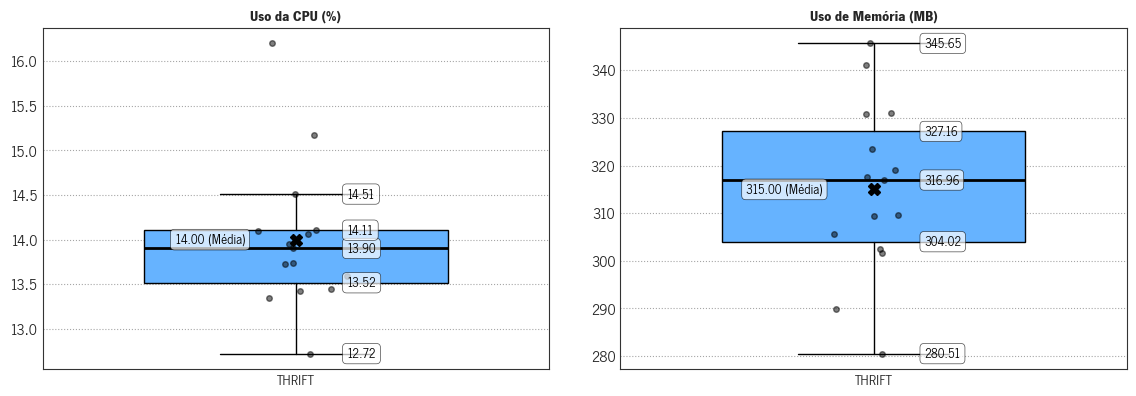

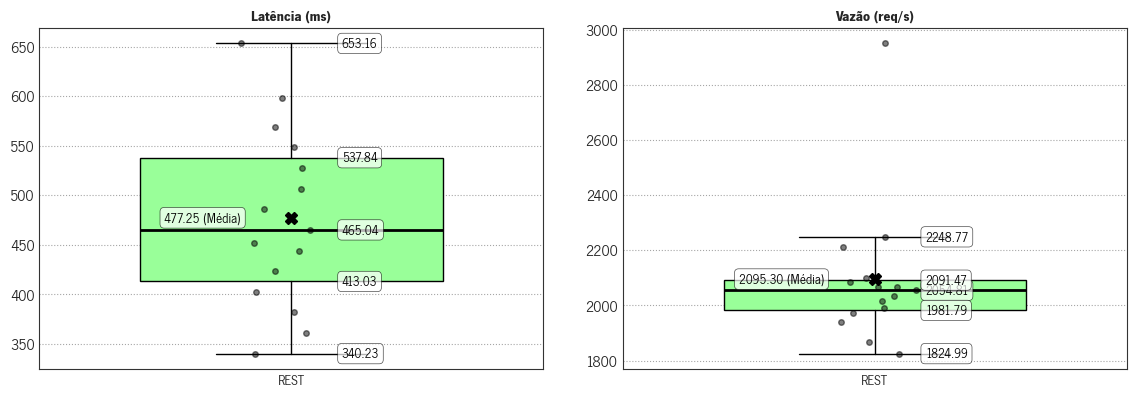

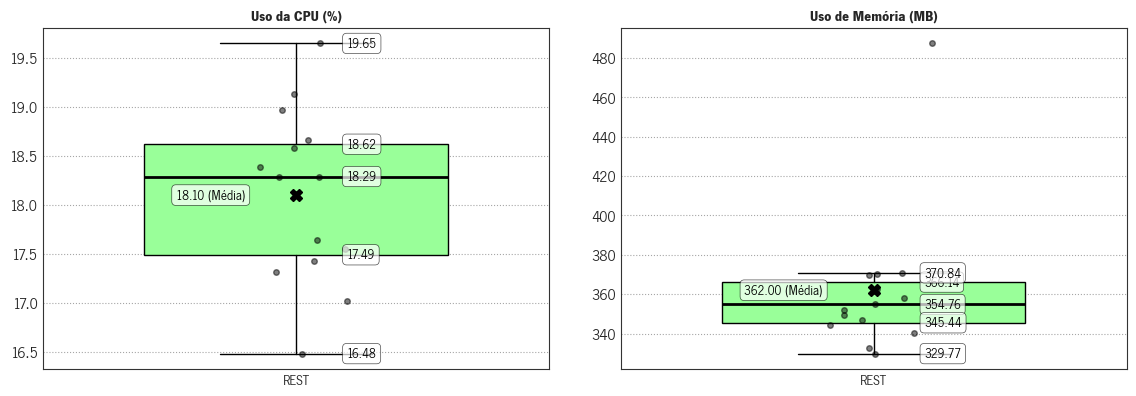

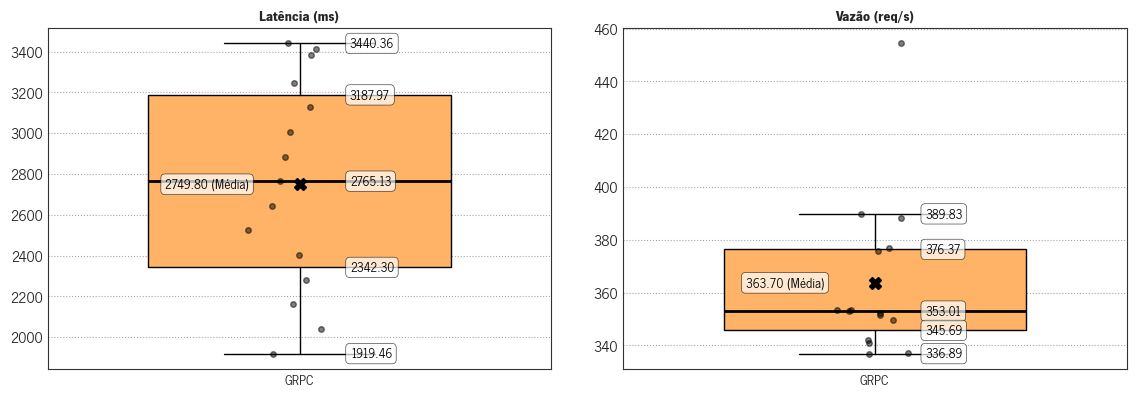

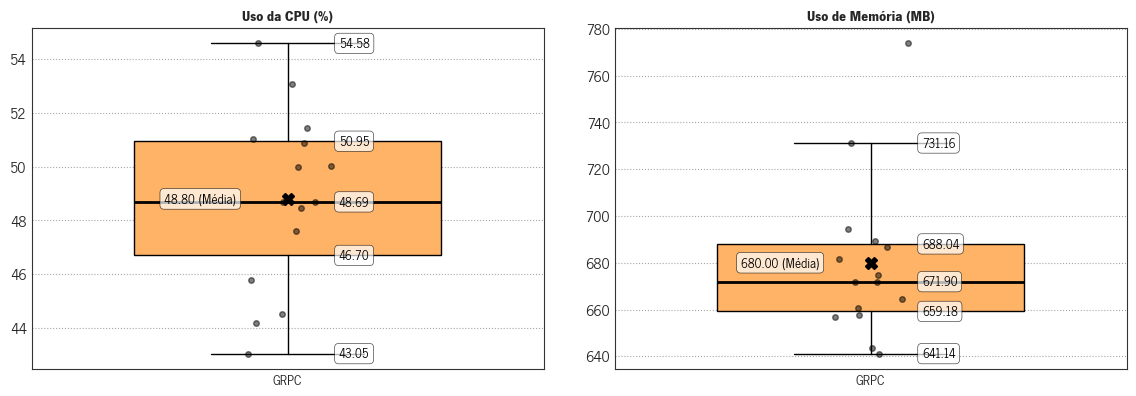

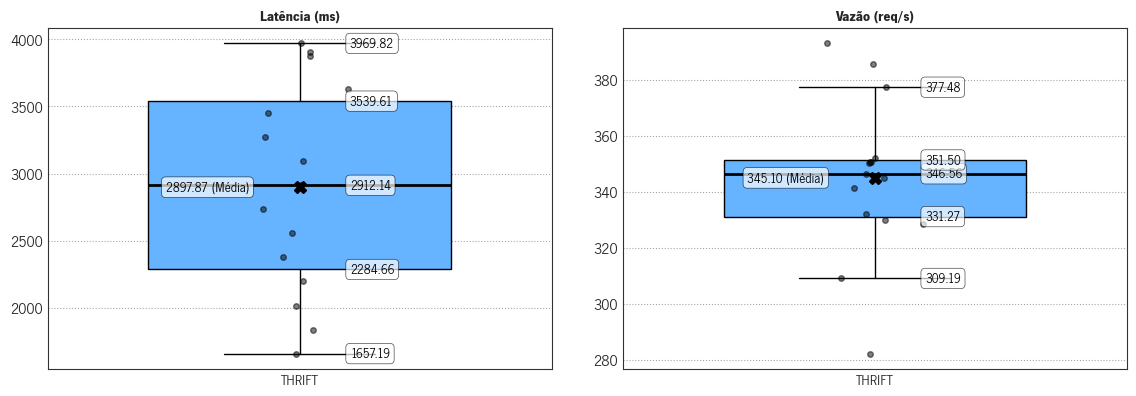

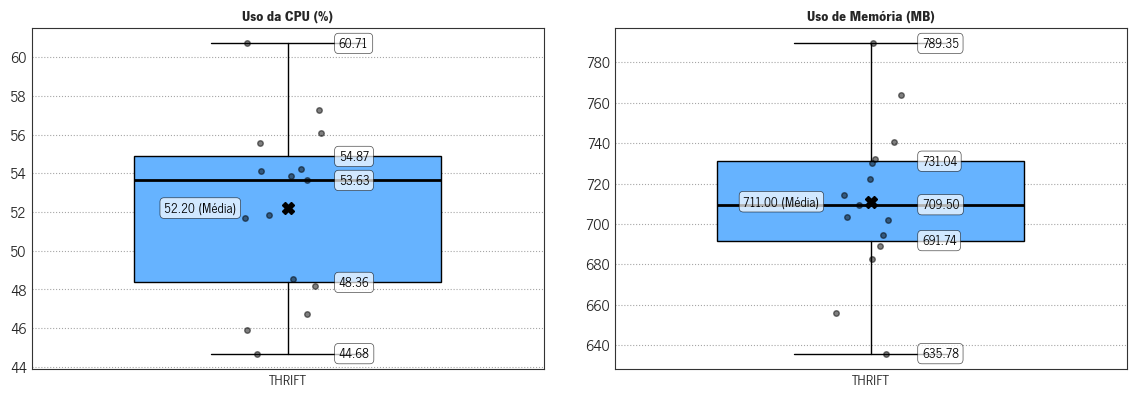

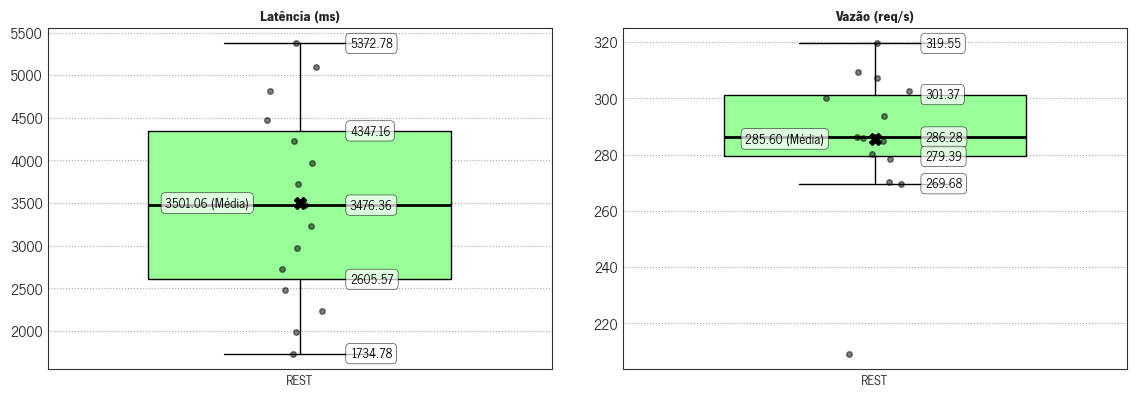

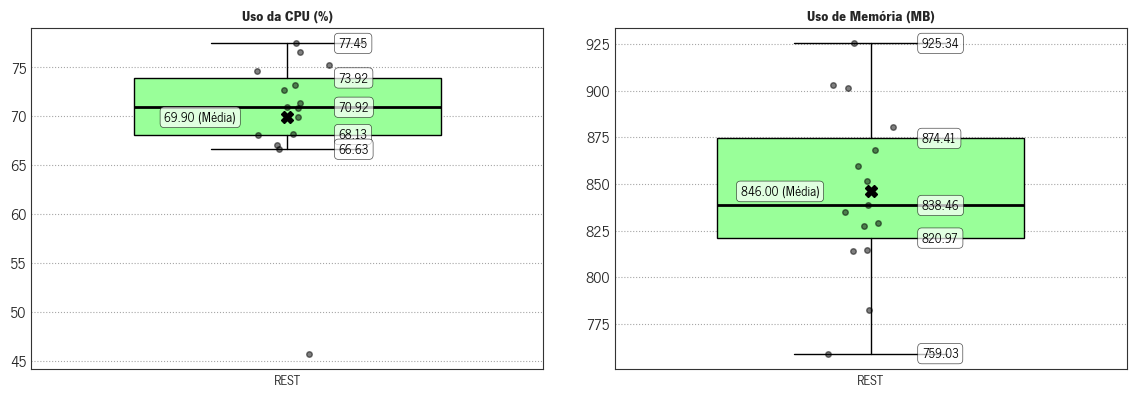

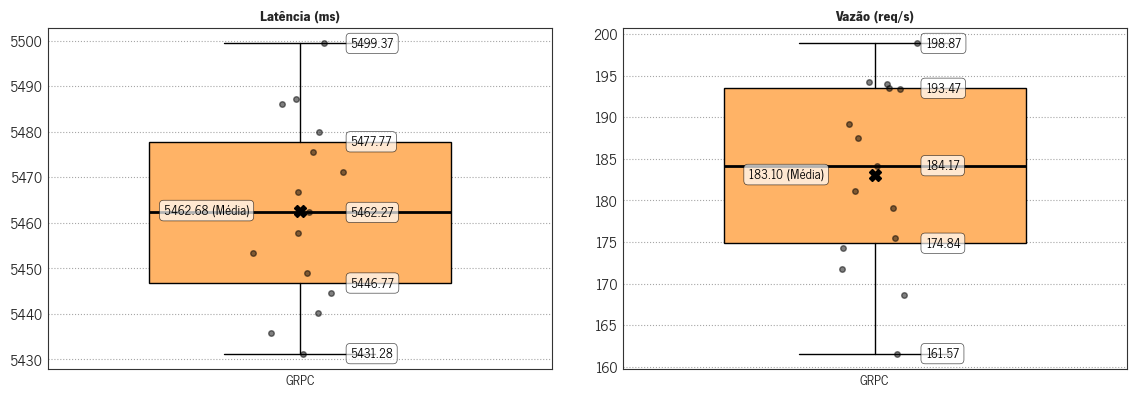

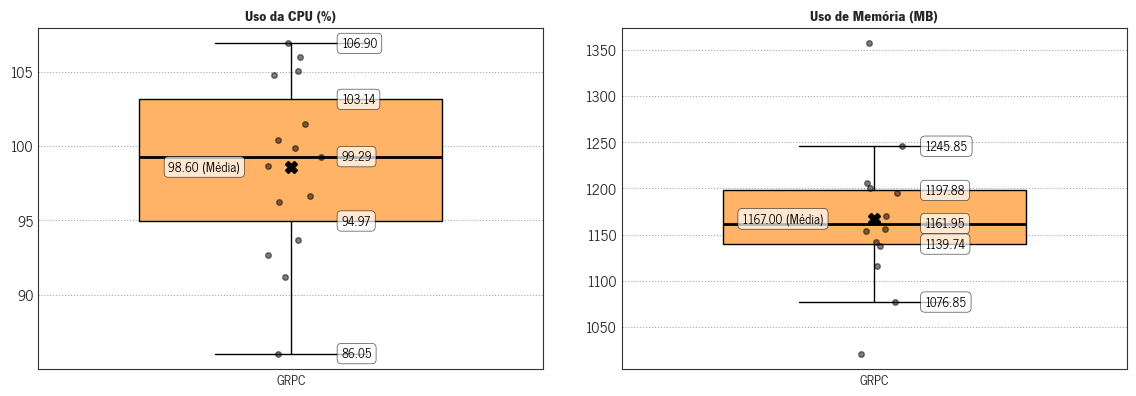

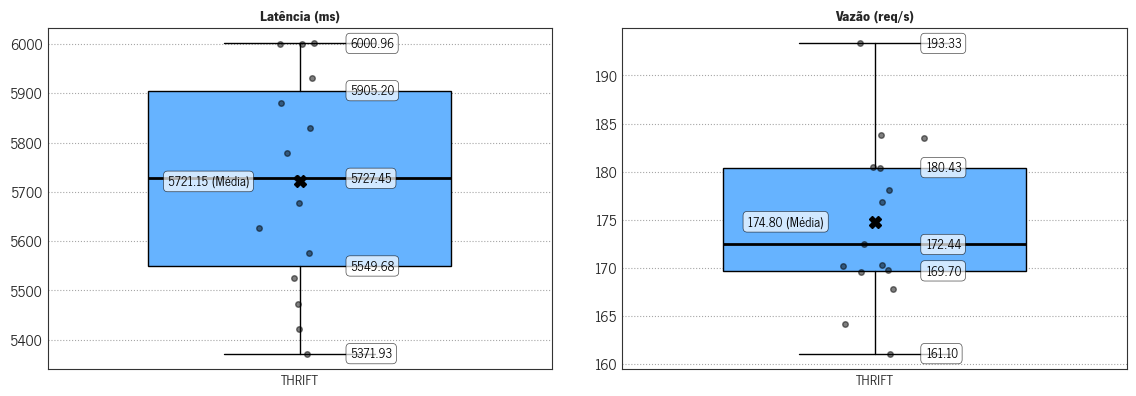

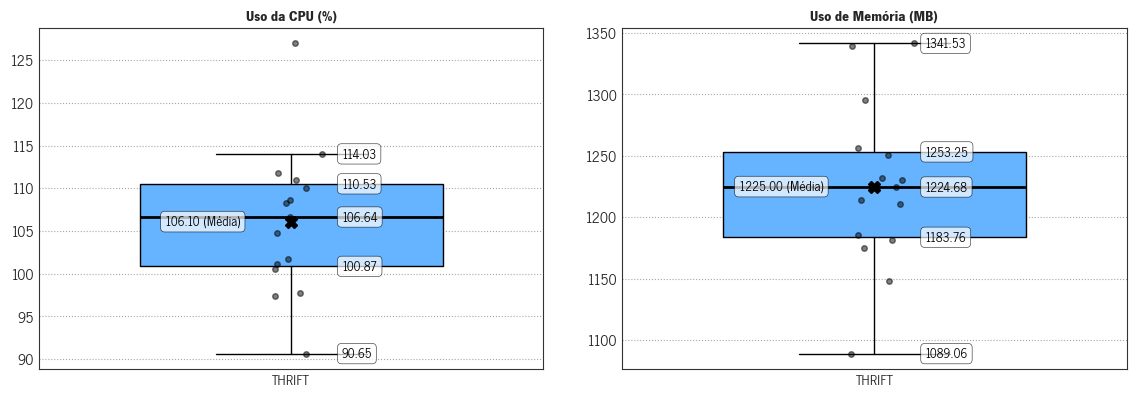

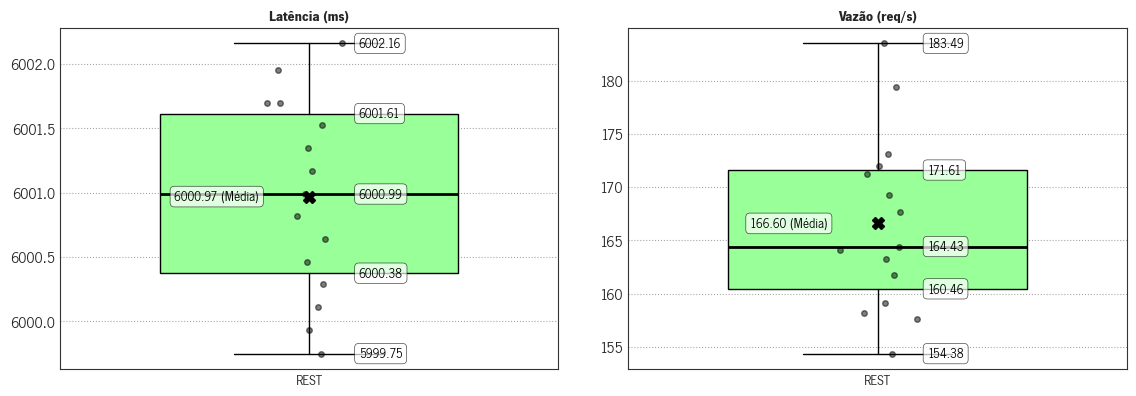

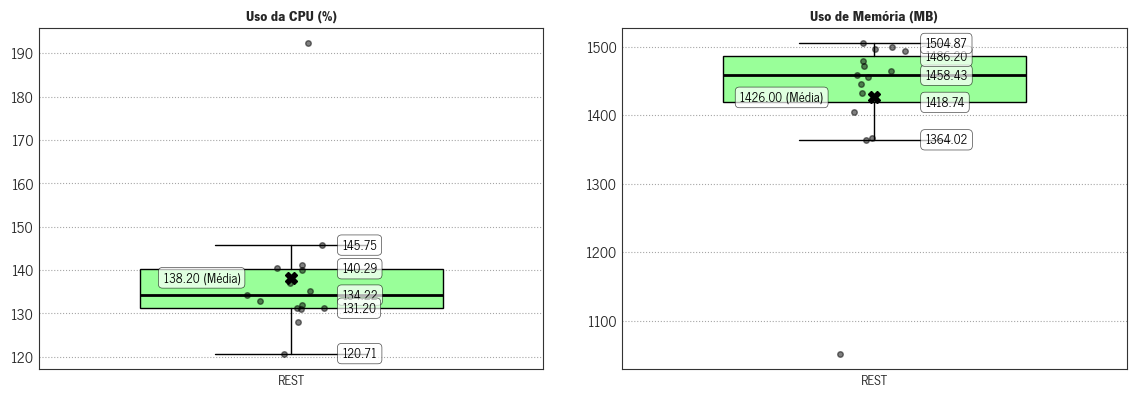

In [8]:
# %%
# Adicionando fontes personalizadas
font_path_regular = './fonts/NewsGotT.ttf'
font_path_bold = './fonts/NewsGotTBold.ttf'

# Adiciona as fontes ao gerenciador de fontes do Matplotlib
try:
    fm.fontManager.addfont(font_path_regular)
    fm.fontManager.addfont(font_path_bold)
except Exception as e:
    print(f"Erro ao adicionar fontes personalizadas: {e}")
    font_regular = 'sans-serif'
    font_bold = 'sans-serif'
else:
    # Define font names
    try:
        font_regular = fm.FontProperties(fname=font_path_regular).get_name()
        font_bold = fm.FontProperties(fname=font_path_bold).get_name()
    except ValueError:
        print("Erro carregando a fonte custom")
        font_regular = 'sans-serif'
        font_bold = 'sans-serif'

# Configure plot style to match example
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = font_regular
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.8

# Define métricas para plotar (removendo flechas)
metrics = {
    'latency_ms': 'Latência (ms)',
    'cpu_usage_percent': 'Uso da CPU (%)',
    'memory_usage_mb': 'Uso de Memória (MB)',
    'throughput_req_s': 'Vazão (req/s)'
}

# Usando o DataFrame df_results carregado anteriormente
df = df_results

# Obtém as combinações únicas de cenário e protocolo
scenarios = df['scenario'].unique()
protocols = df['protocol'].unique()

# Itera sobre cada combinação única de cenário e protocolo
for scenario in scenarios:
    for protocol in protocols:
        # Filtra os dados para o cenário e protocolo atual
        subset_df = df[(df['scenario'] == scenario) &
                       (df['protocol'] == protocol)]

        # Verifica se há dados para plotar
        if not subset_df.empty:
            # --- Primeiro gráfico: Latência e Vazão ---
            fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))

            # Métricas para o primeiro gráfico
            metrics1 = ['latency_ms', 'throughput_req_s']

            for i, metric in enumerate(metrics1):
                ax = axes1[i]
                title = metrics[metric]

                # Cria o box plot sem os outliers, mas calcula a média
                box = ax.boxplot(subset_df[metric], patch_artist=True, widths=0.6, showfliers=False, showmeans=True, meanprops={
                                 "marker": "X", "markerfacecolor": "black", "markeredgecolor": "black", "markersize": 8})

                # Personaliza as cores
                plt.setp(box['boxes'], facecolor=protocol_colors[protocol], edgecolor='black')
                plt.setp(box['whiskers'], color='black', linestyle='-')
                plt.setp(box['caps'], color='black')
                plt.setp(box['medians'], color='black', linewidth=2)

                # Adiciona os pontos de cada amostra
                x = np.random.normal(1, 0.04, size=len(subset_df[metric]))
                ax.plot(x, subset_df[metric], 'o',
                        color='black', markersize=4, alpha=0.5)

                # Configura os títulos e rótulos
                ax.set_title(title, fontsize=14, fontweight='bold',
                             fontproperties=fm.FontProperties(fname=font_path_bold))
                ax.set_xticks([1])
                ax.set_xticklabels([protocol.upper(
                )], fontsize=12, fontproperties=fm.FontProperties(fname=font_path_regular))
                ax.tick_params(axis='y', labelsize=12)

                # Adiciona a grade pontilhada
                ax.yaxis.grid(True, linestyle='dotted',
                              which='major', color='gray', alpha=0.7)
                ax.xaxis.grid(False)

                # Add values to plot with white background
                bbox_props = dict(boxstyle="round,pad=0.3",
                                  fc="white", ec="black", lw=0.5, alpha=0.7)

                # Mediana
                median = box['medians'][0].get_ydata()[0]
                ax.text(1.1, median, f'{median:.2f}', va='center', ha='left', fontsize=10, color='black',
                        bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

                # Quartis
                q1 = box['boxes'][0].get_path().vertices[0, 1]
                q3 = box['boxes'][0].get_path().vertices[2, 1]
                ax.text(1.1, q1, f'{q1:.2f}', va='center', ha='left', fontsize=10, color='black',
                        bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))
                ax.text(1.1, q3, f'{q3:.2f}', va='center', ha='left', fontsize=10, color='black',
                        bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

                # Whiskers
                lower_whisker = box['whiskers'][0].get_ydata()[1]
                upper_whisker = box['whiskers'][1].get_ydata()[1]
                ax.text(1.1, lower_whisker, f'{lower_whisker:.2f}', va='center', ha='left', fontsize=10,
                        color='black', bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))
                ax.text(1.1, upper_whisker, f'{upper_whisker:.2f}', va='center', ha='left', fontsize=10,
                        color='black', bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

                # Média
                mean = box['means'][0].get_ydata()[0]
                ax.text(0.9, mean, f'{mean:.2f} (Média)', va='center', ha='right', fontsize=10,
                        color='black', bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

            plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=3.0)
            # Salva arquivo no padrão 5-resultados-<cenario>-<protocolo>-k6.png
            plt.savefig(f'images/5-resultados-{scenario}-{protocol}-k6.png')
            plt.show()

            # --- Segundo gráfico: Uso de CPU e Memória ---
            fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

            # Métricas para o segundo gráfico
            metrics2 = ['cpu_usage_percent', 'memory_usage_mb']

            for i, metric in enumerate(metrics2):
                ax = axes2[i]
                title = metrics[metric]

                # Cria o box plot sem os outliers, mas calcula a média
                box = ax.boxplot(subset_df[metric], patch_artist=True, widths=0.6, showfliers=False, showmeans=True, meanprops={
                                 "marker": "X", "markerfacecolor": "black", "markeredgecolor": "black", "markersize": 8})

                # Personaliza as cores
                plt.setp(box['boxes'], facecolor=protocol_colors[protocol], edgecolor='black')
                plt.setp(box['whiskers'], color='black', linestyle='-')
                plt.setp(box['caps'], color='black')
                plt.setp(box['medians'], color='black', linewidth=2)

                # Adiciona os pontos de cada amostra
                x = np.random.normal(1, 0.04, size=len(subset_df[metric]))
                ax.plot(x, subset_df[metric], 'o',
                        color='black', markersize=4, alpha=0.5)

                # Configura os títulos e rótulos
                ax.set_title(title, fontsize=14, fontweight='bold',
                             fontproperties=fm.FontProperties(fname=font_path_bold))
                ax.set_xticks([1])
                ax.set_xticklabels([protocol.upper(
                )], fontsize=12, fontproperties=fm.FontProperties(fname=font_path_regular))
                ax.tick_params(axis='y', labelsize=12)

                # Adiciona a grade pontilhada
                ax.yaxis.grid(True, linestyle='dotted',
                              which='major', color='gray', alpha=0.7)
                ax.xaxis.grid(False)

                # Adicionando os valores ao gráfico com fundo branco
                bbox_props = dict(boxstyle="round,pad=0.3",
                                  fc="white", ec="black", lw=0.5, alpha=0.7)

                # Mediana
                median = box['medians'][0].get_ydata()[0]
                ax.text(1.1, median, f'{median:.2f}', va='center', ha='left', fontsize=10, color='black',
                        bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

                # Quartis
                q1 = box['boxes'][0].get_path().vertices[0, 1]
                q3 = box['boxes'][0].get_path().vertices[2, 1]
                ax.text(1.1, q1, f'{q1:.2f}', va='center', ha='left', fontsize=10, color='black',
                        bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))
                ax.text(1.1, q3, f'{q3:.2f}', va='center', ha='left', fontsize=10, color='black',
                        bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

                # Whiskers
                lower_whisker = box['whiskers'][0].get_ydata()[1]
                upper_whisker = box['whiskers'][1].get_ydata()[1]
                ax.text(1.1, lower_whisker, f'{lower_whisker:.2f}', va='center', ha='left', fontsize=10,
                        color='black', bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))
                ax.text(1.1, upper_whisker, f'{upper_whisker:.2f}', va='center', ha='left', fontsize=10,
                        color='black', bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

                # Mean
                mean = box['means'][0].get_ydata()[0]
                ax.text(0.9, mean, f'{mean:.2f} (Média)', va='center', ha='right', fontsize=10,
                        color='black', bbox=bbox_props, fontproperties=fm.FontProperties(fname=font_path_regular))

            plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=3.0)
            # Salva arquivo no padrão 5-resultados-<cenario>-<protocolo>-prometheus.png
            plt.savefig(f'images/5-resultados-{scenario}-{protocol}-prometheus.png')
            plt.show()

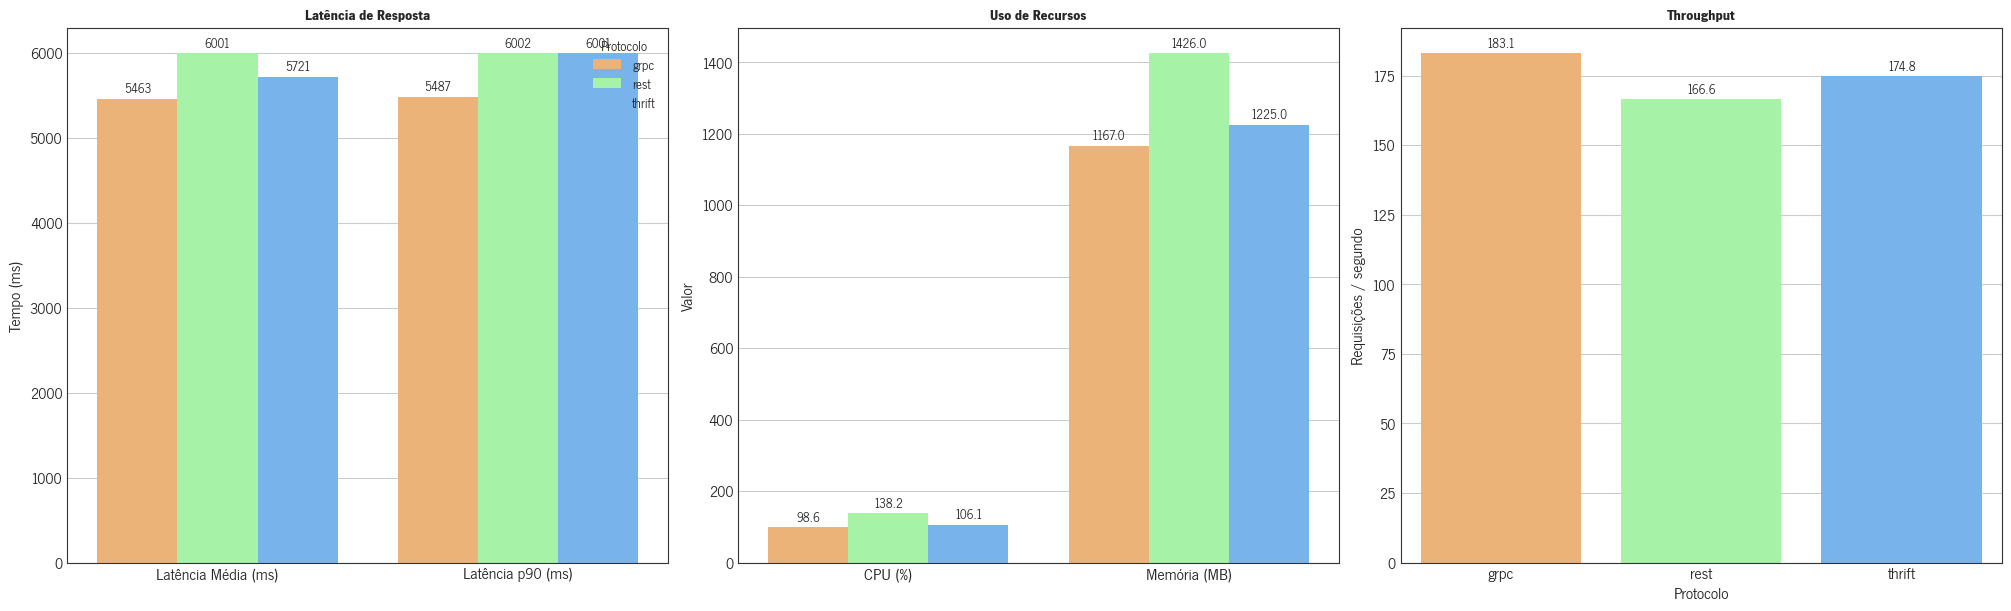

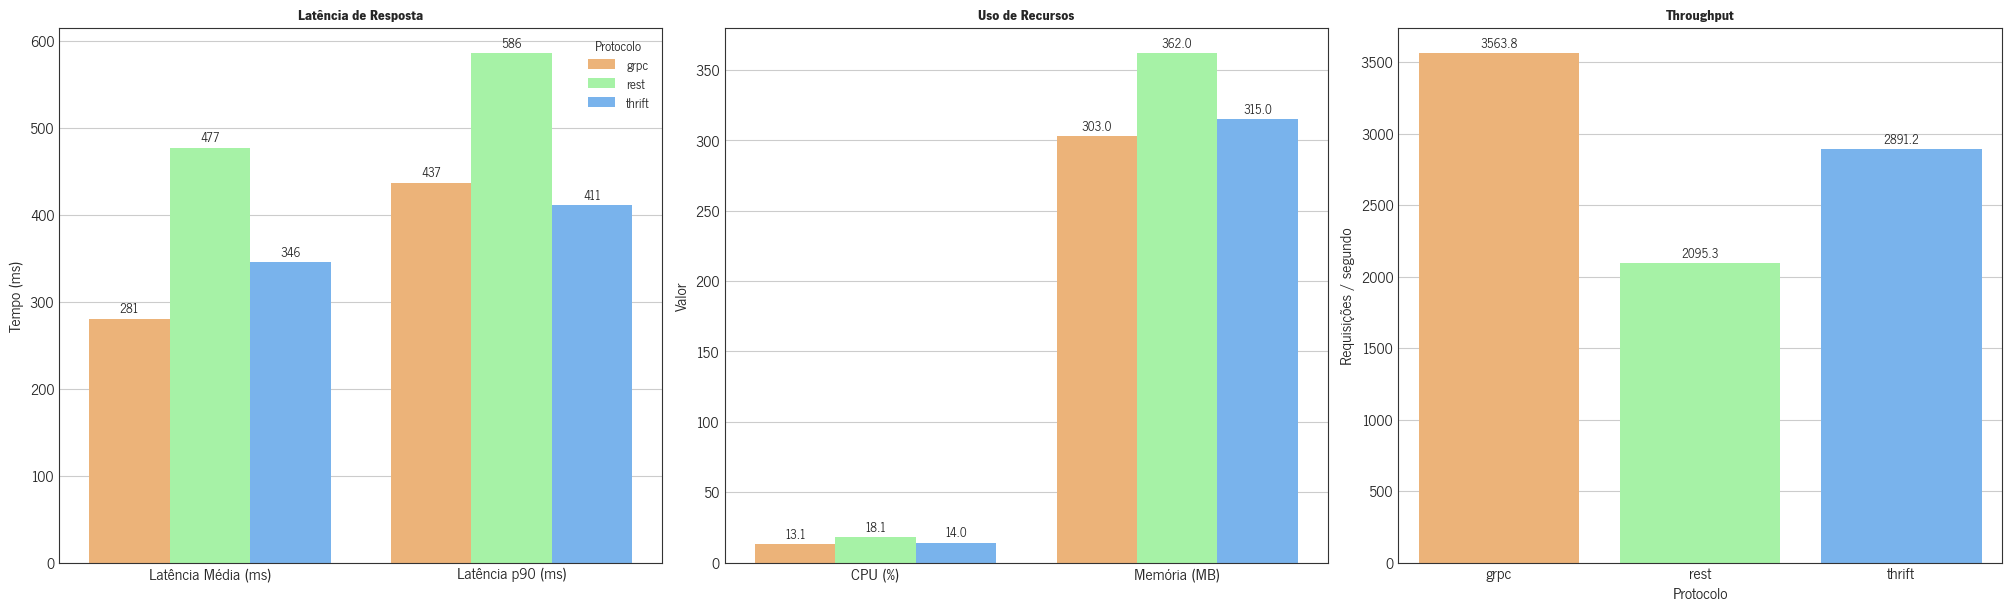

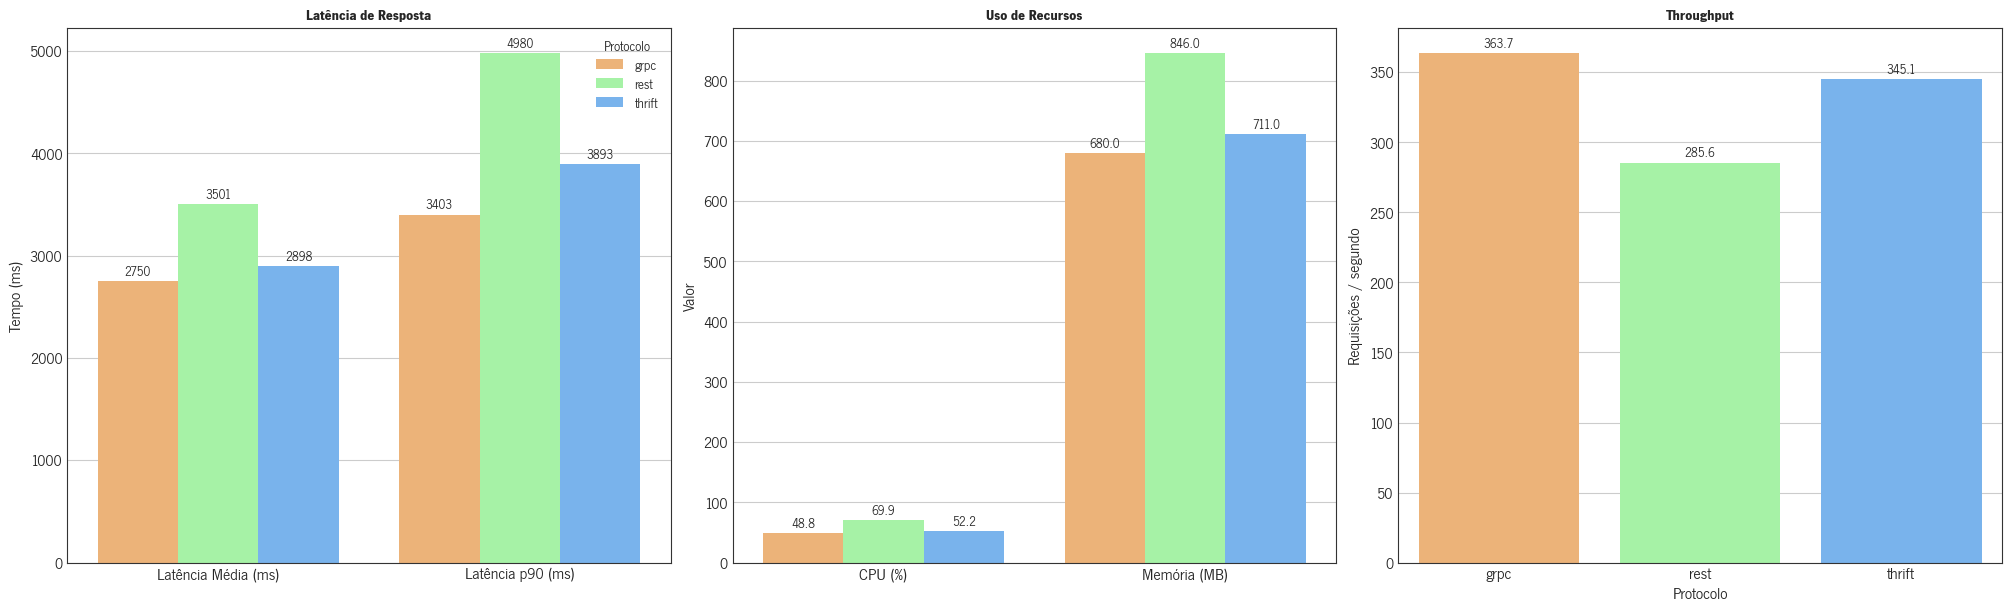

In [9]:
# Usa o DataFrame carregado anteriormente
df = df_results

# Agrupa os dados por 'scenario' e 'protocol' e calcula as métricas solicitadas
summary_df = df.groupby(['scenario', 'protocol']).agg(
    latency_ms_avg=('latency_ms', 'mean'),
    latency_ms_p90=('latency_ms', lambda x: x.quantile(0.90)),
    cpu_usage_percent_avg=('cpu_usage_percent', 'mean'),
    memory_usage_mb_avg=('memory_usage_mb', 'mean'),
    throughput_req_s_avg=('throughput_req_s', 'mean')
).reset_index() # Reseta o índice para transformar 'scenario' e 'protocol' em colunas


# Adiciona fontes personalizadas (verifica se os caminhos estão corretos)
font_path_regular = './fonts/NewsGotT.ttf'
font_path_bold = './fonts/NewsGotTBold.ttf'

# Adiciona as fontes ao gerenciador de fontes do Matplotlib
try:
    fm.fontManager.addfont(font_path_regular)
    fm.fontManager.addfont(font_path_bold)
except Exception as e:
    print(f"Erro ao adicionar fontes personalizadas: {e}")
    font_regular = 'sans-serif'
    font_bold = 'sans-serif'
else:
    # Define os nomes das fontes
    try:
        font_regular = fm.FontProperties(fname=font_path_regular).get_name()
        font_bold = fm.FontProperties(fname=font_path_bold).get_name()
    except ValueError:
         print("Erro na fonte")
         font_regular = 'sans-serif'
         font_bold = 'sans-serif'


# Configura o estilo dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = font_regular
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.8

def plot_scenario_summary(data, scenario_name, palette, regular_font, bold_font):
    # Cria a figura e os eixos para 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

    # Filtra os dados para o cenário atual
    scenario_data = data[data['scenario'] == scenario_name].copy()

    # --- Gráfico 1: Latência (ms) ---
    latency_metrics = {'latency_ms_avg': 'Latência Média (ms)', 'latency_ms_p90': 'Latência p90 (ms)'}
    df_latency = scenario_data.melt(id_vars='protocol', value_vars=latency_metrics.keys(), var_name='Métrica', value_name='Tempo (ms)')

    # Mapeia os nomes das métricas para rótulos mais descritivos
    df_latency['Métrica'] = df_latency['Métrica'].map({'latency_ms_avg': 'Latência Média (ms)', 'latency_ms_p90': 'Latência p90 (ms)'})

    ax1 = sns.barplot(data=df_latency, x='Métrica', y='Tempo (ms)', hue='protocol', ax=axes[0], palette=palette)
    ax1.set_title('Latência de Resposta', fontsize=14, fontweight='bold', fontproperties=fm.FontProperties(fname=font_path_bold))
    ax1.set_xlabel('')
    ax1.set_ylabel('Tempo (ms)', fontsize=12, fontproperties=fm.FontProperties(fname=font_path_regular))
    ax1.legend(title='Protocolo', prop=fm.FontProperties(fname=font_path_regular))
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    # Adiciona os valores no topo das barras
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.0f', fontsize=10, padding=3, fontproperties=fm.FontProperties(fname=font_path_regular))


    # --- Gráfico 2: Uso de Recursos ---
    resource_metrics = {'cpu_usage_percent_avg': 'Uso de CPU (%)', 'memory_usage_mb_avg': 'Uso de Memória (MB)'}
    df_resources = scenario_data.melt(id_vars='protocol', value_vars=resource_metrics.keys(), var_name='Métrica', value_name='Valor')

    # Mapeia os nomes das métricas para rótulos mais descritivos
    df_resources['Métrica'] = df_resources['Métrica'].map({'cpu_usage_percent_avg': 'CPU (%)', 'memory_usage_mb_avg': 'Memória (MB)'})

    ax2 = sns.barplot(data=df_resources, x='Métrica', y='Valor', hue='protocol', ax=axes[1], palette=palette)
    ax2.set_title('Uso de Recursos', fontsize=14, fontweight='bold', fontproperties=fm.FontProperties(fname=font_path_bold))
    ax2.set_xlabel('')
    ax2.set_ylabel('Valor', fontsize=12, fontproperties=fm.FontProperties(fname=font_path_regular))
    if ax2.get_legend():
        ax2.get_legend().remove() # Remove legenda redundante
    ax2.tick_params(axis='y', labelsize=12)
    ax2.tick_params(axis='x', labelsize=12)
    # Adiciona os valores no topo das barras
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f', fontsize=10, padding=3, fontproperties=fm.FontProperties(fname=font_path_regular))


    # --- Gráfico 3: Throughput (requisições/s) ---
    ax3 = sns.barplot(data=scenario_data, x='protocol', y='throughput_req_s_avg', hue='protocol', ax=axes[2], dodge=False, palette=palette)
    ax3.set_title('Throughput', fontsize=14, fontweight='bold', fontproperties=fm.FontProperties(fname=font_path_bold))
    ax3.set_xlabel('Protocolo', fontsize=12, fontproperties=fm.FontProperties(fname=font_path_regular))
    ax3.set_ylabel('Requisições / segundo', fontsize=12, fontproperties=fm.FontProperties(fname=font_path_regular))
    if ax3.get_legend():
        ax3.get_legend().remove() # Remove legenda redundante
    ax3.tick_params(axis='y', labelsize=12)
    ax3.tick_params(axis='x', labelsize=12)
    # Adiciona os valores no topo das barras
    for container in ax3.containers:
        ax3.bar_label(container, fmt='%.1f', fontsize=10, padding=3, fontproperties=fm.FontProperties(fname=font_path_regular))

    plt.savefig(f'images/5-resultados-{scenario}.png')
    plt.show()


# --- 4. Geração dos Gráficos para cada Cenário ---

for scenario in summary_df['scenario'].unique():
    plot_scenario_summary(summary_df, scenario, protocol_colors, font_regular, font_bold)